In [1]:
# %%
import pandas as pd
import numpy as np
from scipy import stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import argparse
from tools.analysis.statistical_analysis_tools import *
import os
import logging

# %%
from pypalettes import load_cmap
alexandrite = load_cmap("Alexandrite")
emrld = load_cmap("Emrld", reverse=True)

# %%

DATA_DIR = os.path.join("../data")
FIGURES_DIR = os.path.join("../reports/figures")

In [2]:
logging.basicConfig(level=logging.INFO)
dataset_name = 'hepatitis'

# %%
logging.info(f"Loading results data for {dataset_name}")
knn_results_filename = f"{DATA_DIR}/per_fold_results/knn_{dataset_name}.csv"
knn_reduction_results_filename = f"{DATA_DIR}/per_fold_results/knn_reduction_{dataset_name}.csv"
svm_results_filename = f"{DATA_DIR}/per_fold_results/svm_{dataset_name}.csv"

knn_results = pd.read_csv(knn_results_filename)
knn_reduction_results = pd.read_csv(knn_reduction_results_filename)
svm_results = pd.read_csv(svm_results_filename)

# %%
f1_cols = [f"f1_{i}" for i in range(10)]
train_time_cols = [f"train_time_{i}" for i in range(10)]
test_time_cols = [f"test_time_{i}" for i in range(10)]
storage_cols = [f"storage_{i}" for i in range(10)]

for df in [knn_results, knn_reduction_results, svm_results]:
    df['mean_f1_score'] = df[f1_cols].mean(axis=1)
    df['mean_train_time'] = df[train_time_cols].mean(axis=1)
    df['mean_test_time'] = df[test_time_cols].mean(axis=1)
knn_reduction_results['mean_storage'] = knn_reduction_results[storage_cols].mean(axis=1)

knn_results["model_label"] = knn_results.apply(get_knn_model_label, axis=1)
knn_reduction_results["model_label"] = knn_reduction_results.apply(
    get_knn_reduction_model_label, axis=1
)
svm_results["model_label"] = svm_results.apply(get_svm_model_label, axis=1)


INFO:root:Loading results data for hepatitis


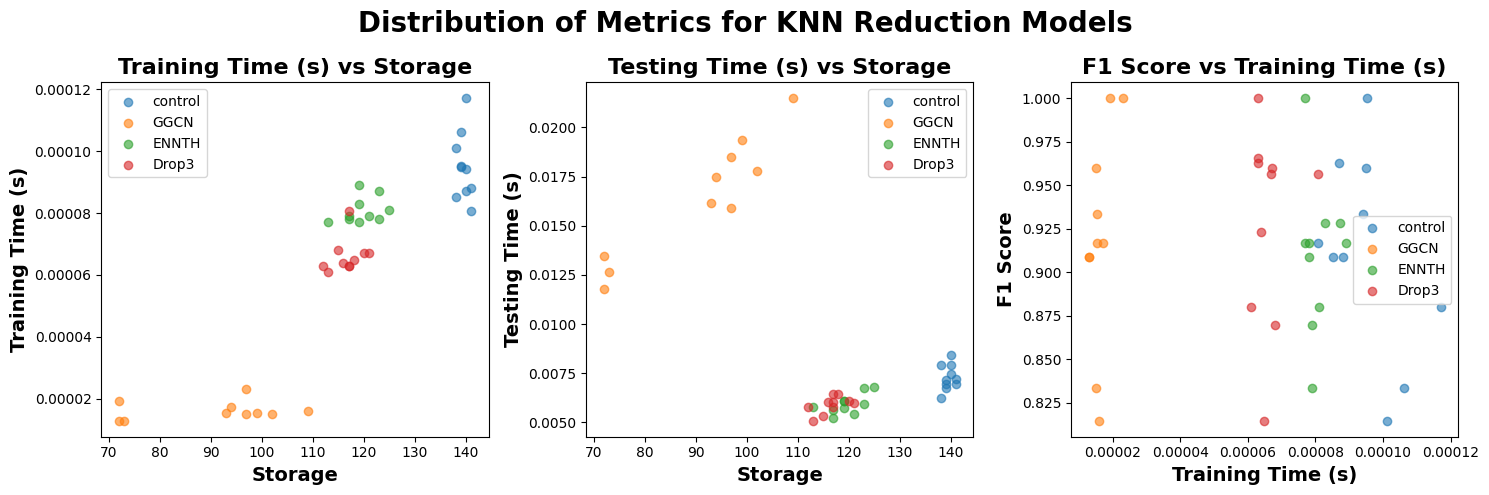

In [3]:
metric_cols_map = {
    "Storage": storage_cols,
    "Training Time (s)": train_time_cols,
    "Testing Time (s)": test_time_cols,
    "F1 Score": f1_cols
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for (metric_a, metric_b), ax in zip([("Storage", "Training Time (s)"), ("Storage", "Testing Time (s)"), ("Training Time (s)", "F1 Score")], axes):

    for idx in knn_reduction_results.index:
        metric_a_values = knn_reduction_results.loc[idx, metric_cols_map[metric_a]].values   
        metric_b_values = knn_reduction_results.loc[idx, metric_cols_map[metric_b]].values
        ax.scatter(metric_a_values, metric_b_values, alpha=0.6, label=knn_reduction_results.loc[idx, "reduction_func"])
    ax.set_title(f"{metric_b} vs {metric_a}", fontsize=16, fontweight="bold")
    ax.set_xlabel(metric_a, fontsize=14, fontweight="bold")
    ax.set_ylabel(metric_b, fontsize=14, fontweight="bold")
    ax.legend()
fig.suptitle(f'Distribution of Metrics for KNN Reduction Models', fontsize=20, fontweight="bold")
plt.tight_layout()
plt.show()
# %%

In [4]:
friedman_test(knn_reduction_results, train_time_cols)

(np.float64(28.090909090909093), np.float64(3.4759051716687857e-06))

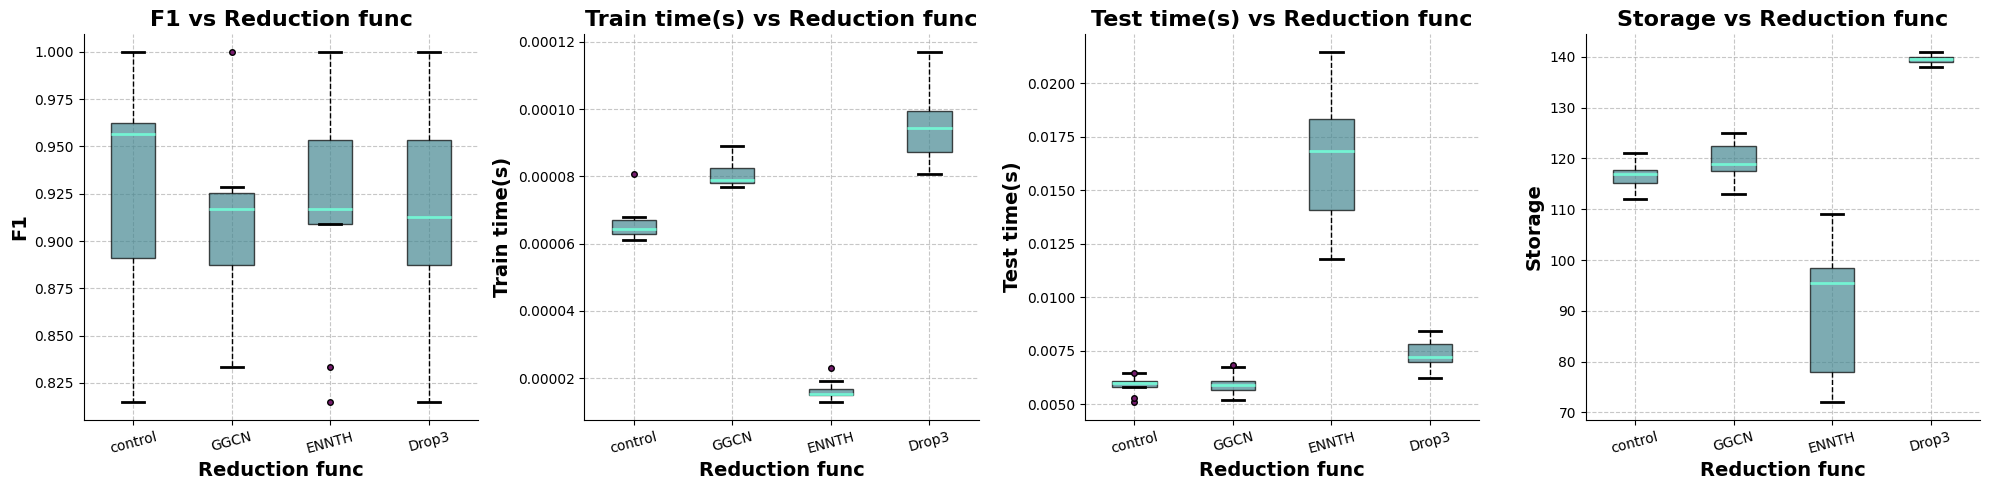

In [5]:
expanded_reduction_results = pd.DataFrame([
    {
        'reduction_func': row['reduction_func'],
        'f1': row[f'f1_{i}'],
        'train_time': row[f'train_time_{i}'],
        'test_time': row[f'test_time_{i}'],
        'storage': row[f'storage_{i}']
    }
    for _, row in knn_reduction_results.iterrows()
    for i in range(10)
])

plot_independent_effects(expanded_reduction_results, ["reduction_func"], y_cols=["f1","train_time", "test_time", "storage"])
plt.show()
# %%
